In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [6]:
stockNo = "2330.TW"
start_date = '2014-01-01'
data = yf.download(stockNo, start=start_date).reset_index()
data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,105.0,105.5,103.5,104.5,77.713982,15071000
1,2014-01-03,103.0,103.0,102.0,102.5,76.226624,38599000
2,2014-01-06,102.0,103.0,102.0,102.5,76.226624,23706000
3,2014-01-07,102.5,103.0,102.0,102.0,75.854782,15836000
4,2014-01-08,103.0,104.5,102.5,104.0,77.342148,30218000
...,...,...,...,...,...,...,...
2444,2024-01-08,582.0,585.0,579.0,583.0,583.000000,17761275
2445,2024-01-09,588.0,589.0,583.0,586.0,586.000000,22501510
2446,2024-01-10,581.0,586.0,580.0,584.0,584.000000,13037716
2447,2024-01-11,586.0,589.0,583.0,586.0,586.000000,23997409


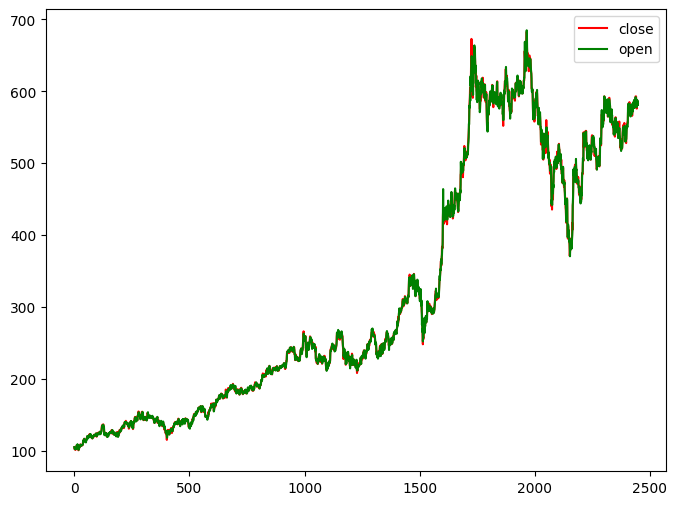

In [11]:
fig=plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(111)
ax1.plot(data["Close"], color='red', label='close')
ax1.plot(data["Open"], color='green', label='open')
plt.legend()

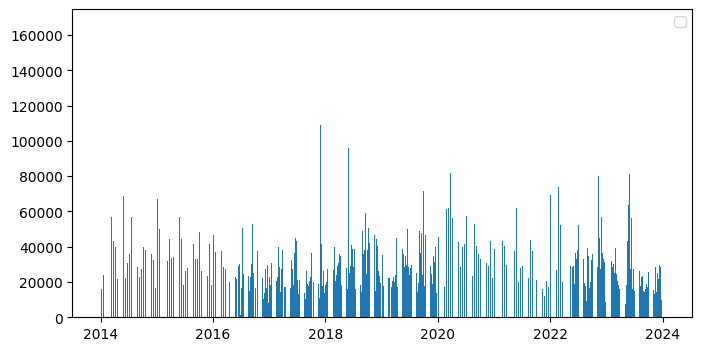

In [8]:
fig=plt.figure(figsize = (8,4))
ax2 = fig.add_subplot(111)
plt.bar(data["Date"],data["Volume"].astype('int')//1000)
plt.legend()

In [59]:
# 2449*0.8=1595 (取前80%的收盤價駔為訓練集)
train_data = data[:1596]["Close"]
test_data = data[1596:]["Close"]

### Normalization

In [39]:
sc = MinMaxScaler(feature_range = (0, 1))

train_data= train_data.values.reshape(-1,1)  # reshape to one column
train_data_scaled = sc.fit_transform(train_data)
train_data_scaled

array([[0.01500938],
       [0.00750469],
       [0.00750469],
       ...,
       [0.98499062],
       [0.96435272],
       [1.        ]])

In [52]:
# 將10天的資料視為一個序列
# 因為序列型資料需要這樣子去呈現才行(X_train),而y_train則是用第i天前的資料來預測第i天的股價的意思。
X_train = []
y_train = []
for i in range(10,len(train_data)):
    X_train.append(train_data_scaled[i-10:i-1, 0])
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# 序列預測的模型(ex.循環神經網絡）期望輸入是三維 (樣本數，時間步長（序列長度），特徵數) 由於是單變量時間序列，所以最後一維被設置為 1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [53]:
X_train[1]
# array([0.00750469, 0.00750469, 0.00562852, 0.01313321, 0.00187617,
#        0.00562852, 0.00938086, 0.01125704, 0.01688555])

array([[0.00750469],
       [0.00750469],
       [0.00562852],
       [0.01313321],
       [0.00187617],
       [0.00562852],
       [0.00938086],
       [0.01125704],
       [0.01688555]])

### Create LSTM model
建立 LSTM 模型，用於進行時間序列的回歸預測。該模型包含一個 LSTM 層和一個全連接 Dense 層，並使用均方誤差作為損失函數。

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,BatchNormalization

In [55]:
keras.backend.clear_session()  #確保在建立新模型之前清除任何先前存在的模型或圖形
regressor = Sequential()
regressor.add(LSTM(units = 100, input_shape = (X_train.shape[1], 1)))  #添加一層LSTM層(100個單元、input_shape:時間步長（序列長度）、每個時間步的特徵數
regressor.add(Dense(units = 1))  #添加一個全連接層(units=1表示該層只有一個神經元) 這是因為這是一個回歸問題，預測單一的數值
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [57]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
100/100 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 6.1460e-04
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 6.2445e-04
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 6.2501e-04
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 6.5565e-04
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 5.9614e-04
Epoch 7/100
100/100 [==============================] - 1s 7ms/step - loss: 5.9393e-04
Epoch 8/100
100/100 [==============================] - 1s 7ms/step - loss: 6.1681e-04
Epoch 9/100
100/100 [==============================] - 1s 7ms/step - loss: 5.5115e-04
Epoch 10/100
100/100 [==============================] - 1s 7ms/step - loss: 5.5316e-04
Epoch 11/100
100/100 [==============================] - 1s 11ms/step - loss: 5.4390e-04
Epoch 12/100
100/100 [==============================] -

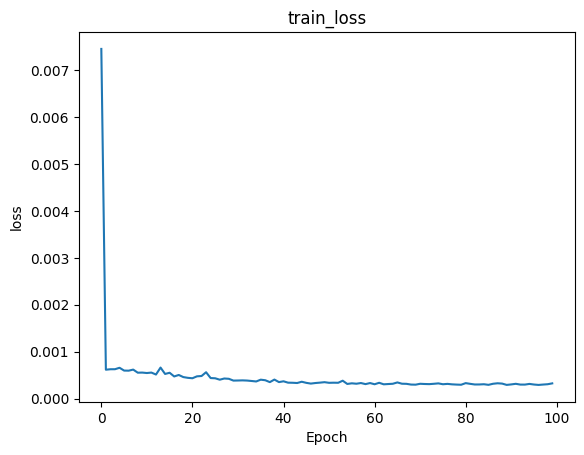

In [56]:
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 16)
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

- 輸入測試集

In [62]:
dataset_total = pd.concat((train_data, test_data), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - 10:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(10, len(inputs)):
    X_test.append(inputs[i-10:i-1, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

27/27 [==============================] - 1s 4ms/step


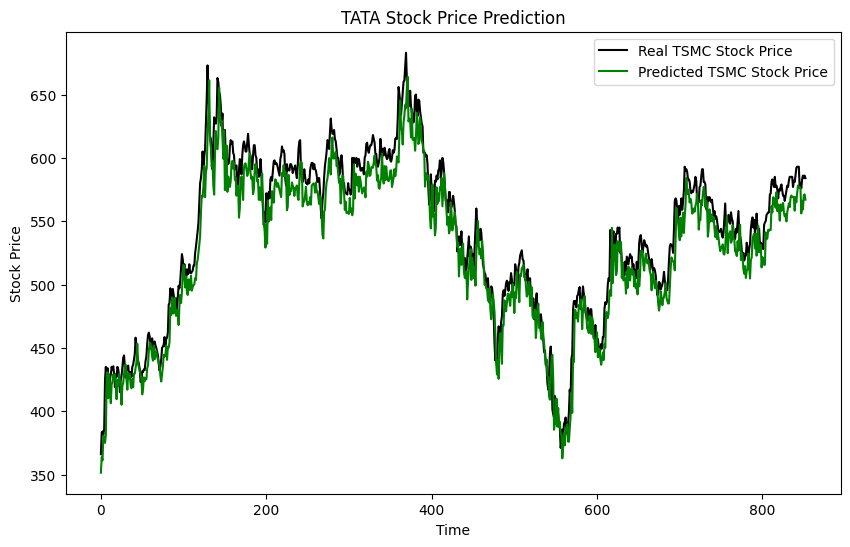

In [66]:
fig=plt.figure(figsize = (10,6))
plt.plot(test_data.values, color = 'black', label = 'Real TSMC Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TSMC Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

- 增加 dropout 層，防止過擬合

In [69]:
keras.backend.clear_session()
regressor = Sequential()
regressor.add(LSTM(units = 100,return_sequences=True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 100,activation='relu'))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [70]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 9, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
100/100 [==============================] - 5s 16ms/step - loss: 0.0141
Epoch 2/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 9.3502e-04
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 8.8414e-04
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 9.7571e-04
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 8.5667e-04
Epoch 8/100
100/100 [==============================] - 2s 16ms/step - loss: 8.0613e-04
Epoch 9/100
100/100 [==============================] - 2s 20ms/step - loss: 9.1862e-04
Epoch 10/100
100/100 [==============================] - 1s 14ms/step - loss: 7.9067e-04
Epoch 11/100
100/100 [==============================] - 1s 13ms/step - loss: 8.3326e-04
Epoch 12/100
100/100 [==============================]

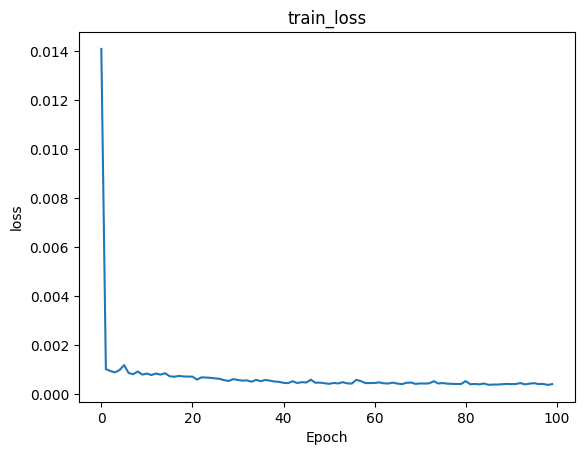

In [71]:
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 16)
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

- https://github.com/grandma-tutorial/Stocker/blob/master/grandma_stocker.ipynb
- https://wenwender.wordpress.com/2019/10/18/%E5%AF%A6%E4%BD%9C%E9%80%8F%E9%81%8Elstm%E9%A0%90%E6%B8%AC%E8%82%A1%E7%A5%A8/